In [19]:
# !pip install evaluate bert-score rouge-score mlflow pandas google-generativeai python-dotenv

In [20]:
import os
import json
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
from tqdm import tqdm

load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

import google.generativeai as genai
genai.configure(api_key=GEMINI_API_KEY)

import evaluate
import mlflow


In [21]:
GT_DIR = Path("../data/ground_truth")
GEN_DIR = Path("../data/generated_data")

files = [f.stem for f in GT_DIR.glob("*.json") if (GEN_DIR / f"{f.stem}.json").exists()]

references = []
predictions = []
file_ids = []

for file_id in files:
    with open(GT_DIR / f"{file_id}.json") as f:
        references.append(json.load(f)["abstract"])

    with open(GEN_DIR / f"{file_id}.json") as f:
        predictions.append(json.load(f)["summary"])

    file_ids.append(file_id)


In [22]:
rouge = evaluate.load("rouge")
bert = evaluate.load("bertscore")

rouge_results = rouge.compute(predictions=predictions, references=references)
bert_results = bert.compute(predictions=predictions, references=references, lang="en")

print("ROUGE:", rouge_results)
print("BERTScore:", bert_results["f1"][:5])  


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE: {'rouge1': np.float64(0.24064511890684534), 'rouge2': np.float64(0.051802790301772865), 'rougeL': np.float64(0.14304296413086323), 'rougeLsum': np.float64(0.14304296413086323)}
BERTScore: [0.8158199787139893, 0.8339284062385559]


In [23]:
import json

def gemini_llm_score(reference, prediction):
    prompt = f"""
You are an evaluation assistant. Compare the generated summary to the reference abstract.

Return a JSON object with:
- similarity_score: an integer from 0.0 to 1.0. 0.0 being the lowest similarity and 1.0 being the highest between the generated summary and the reference abstract.
- correct: true or false
- reason: a short explanation on why you decided on the similarity score and how you determined if the summary is correct or not.

Important: respond in valid JSON only. Do not include markdown or explanation outside the JSON.

Abstract:
{reference}

Generated Summary:
{prediction}
"""

    model = genai.GenerativeModel("models/gemini-1.5-flash-latest")
    
    try:
        response = model.generate_content(prompt)
        reply = response.text.strip()
        json_start = reply.find('{')
        json_end = reply.rfind('}') + 1
        json_str = reply[json_start:json_end]

        parsed = json.loads(json_str)
        return parsed.get("similarity_score"), parsed.get("correct"), parsed.get("reason")
    
    except Exception as e:
        print(f"LLM eval error: {e}")
        return None, None, f"LLM error: {e}"


In [24]:
results = []

for i in tqdm(range(len(predictions))):
    pred = predictions[i]
    ref = references[i]
    file_id = file_ids[i]

    sim_score, correct, reason = gemini_llm_score(ref, pred)

    result = {
        "file": file_id,
        "rouge1": rouge_results["rouge1"],
        "rougeL": rouge_results["rougeL"],
        "bert_f1": bert_results["f1"][i],
        "llm_similarity": sim_score,
        "llm_correct": correct,
        "llm_reason": reason
    }
    results.append(result)

df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
df.head()

# Daten im csv speichern - dont know if this is needed
# output_csv_path = Path("../data/evaluation_results.csv") 
# df.to_csv(output_csv_path, index=False)

100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


,file,rouge1,rougeL,bert_f1,llm_similarity,llm_correct,llm_reason
0,Does_the_categorization_difficulty_elicit_the_uncanny-valley-like_phenomenon_without_animacy,0.240645,0.143043,0.815820,0.8,True,"The generated summary accurately captures the main research question, methodology (using morphed geometric shapes and measuring categorization time and likeability), and the key finding that categorization difficulty, not processing fluency, is the primary factor contributing to the uncanny valley effect with non-animate objects. The summary is concise and well-written, covering the essential aspects of the study. While some details are omitted (like the specific experiments), the core message and conclusion are preserved, making it a highly accurate and informative summary."
1,VerilogReader_LLM-Aided_Hardware_Test_Generation,0.240645,0.143043,0.833928,0.7,True,"The generated summary accurately captures the main points of the abstract, including the use of LLMs for coverage-directed test generation, the role of the LLM as a Verilog reader, the comparison with random testing, and the limitations of the approach for complex designs. The mention of ""Coverage Explainer"" and ""DUT Explainer"" and JSON output are details not explicitly present in the abstract but are consistent with the general approach. While the abstract mentions prompt engineering optimization, the summary focuses on the limitations and future work, which is a reasonable alternative emphasis. The overall information conveyed is highly similar, resulting in a similarity score of 0.7."


In [25]:
import matplotlib.pyplot as plt

VIS_DIR = Path("../data/visual_data")
VIS_DIR.mkdir(parents=True, exist_ok=True)

metrics_to_plot = ["rouge1", "rougeL", "bert_f1", "llm_similarity"]

with mlflow.start_run():
    for _, row in df.iterrows():
        file = row["file"]

        for metric in metrics_to_plot:
            val = row.get(metric)
            if pd.notnull(val):
                mlflow.log_metric(f"{file}_{metric}", val)

        if row.get("llm_correct") is not None:
            mlflow.set_tag(f"{file}_llm_correct", row["llm_correct"])
        if row.get("llm_reason"):
            mlflow.set_tag(f"{file}_llm_reason", row["llm_reason"])

        values = [row[m] if pd.notnull(row[m]) else 0 for m in metrics_to_plot]

        plt.figure(figsize=(8, 5))
        plt.bar(metrics_to_plot, values, color='skyblue')
        plt.ylim(0, 10 if max(values) > 1 else 1)
        plt.title(f"Metrics for {file}")
        plt.ylabel("Score")
        plt.xticks(rotation=45)
        plt.tight_layout()

        fname = VIS_DIR / f"{file}_metrics.png"
        plt.savefig(fname)
        mlflow.log_artifact(str(fname))
        plt.close()

mlflow.end_run()

In [26]:
# Jetzt zum directory /notebooks wechseln
# und dann  "mlflow ui" im Terminal ausführen (it only runs locally)
# und im Browser auf http://localhost:5000 gehen, um die Metriken zu sehen. 

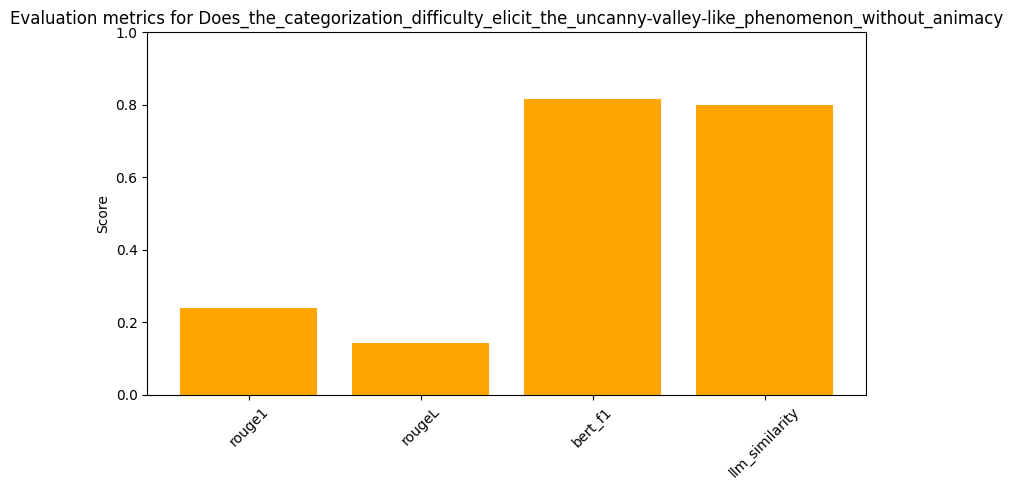

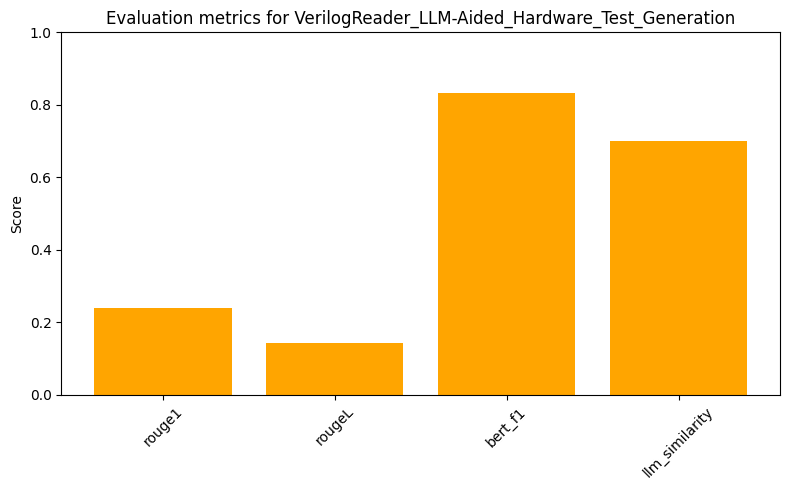

In [27]:
metrics_to_plot = ["rouge1", "rougeL", "bert_f1", "llm_similarity"]
values = [row[m] for m in metrics_to_plot]

for _, row in df.iterrows():
    values = [row[m] for m in metrics_to_plot]

    plt.figure(figsize=(8, 5))
    plt.bar(metrics_to_plot, values, color='orange')
    plt.ylim(0, 1)
    plt.title(f"Evaluation metrics for {row['file']}")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
